# Mixture Model

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import scipy.stats as stats
import theano.tensor as T

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Let's suppose that there are two random variables, $x_1$ and $x_2$, following two normal distributions, respectively:
$$
x_1 \sim \mathcal{N}(3,2^2)\\
x_2 \sim \mathcal{N}(\text{-}3,1^2)
$$

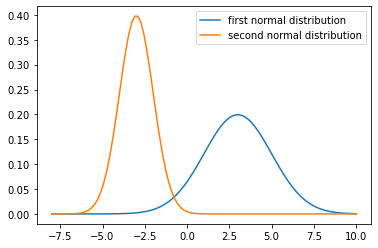

In [41]:
plt.plot(np.linspace(-8,10,100), stats.norm.pdf(np.linspace(-8,10,100), loc=3, scale=2), label='first normal distribution')
plt.plot(np.linspace(-8,10,100), stats.norm.pdf(np.linspace(-8,10,100), loc=-3, scale=1), label='second normal distribution')
plt.legend()
plt.show()

Let's draw 100 samples from each distribution. The set of 200 samples is our dataset in this example.

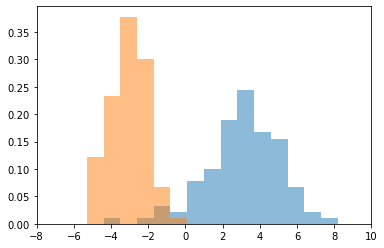

In [95]:
np.random.seed(1234) # for reproducibility
x1 = np.random.randn(100)*2+3 # first distribution, mean:3, std:2
x2 = np.random.randn(100)*1-3 # second distribution, mean:-3, std:1
plt.hist(x1, density=True, alpha=0.5, bins=20, range=(-8,10))
plt.hist(x2, density=True, alpha=0.5, bins=20, range=(-8,10))
plt.xlim(-8,10)
plt.show()

Assume that we do not know the two distributions a priori. Now, we want to fit a normal distribution (estimating $\mu$ and $\sigma$) to our dataset.

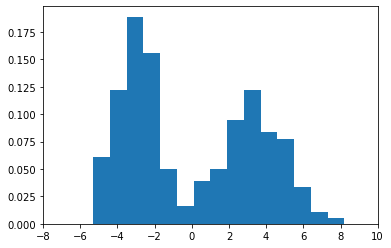

In [96]:
All = np.hstack((x1,x2))
plt.hist(All, density=True, bins=20, range=(-8,10))
plt.xlim(-8,10)
plt.show()

Let's construct our model. Again, all we want is estimating $\mu$ and $\sigma$

In [73]:
model_all = pm.Model()
with model_all:
    mu = pm.Normal('mu', mu=0, sd=10) # mu
    std = pm.Exponential('std', lam=1/10.) # sigma
    obs = pm.Normal('obs', mu=mu, sd=std, observed=All) # likelihood, normal distribution
    trace = pm.sample(draws=5000)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_20220/1620962171.py:6: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 39 seconds.
The acceptance probability does not match the target. It is 0.8829786223014844, but should be close to 0.8. Try to increase the number of tuning steps.


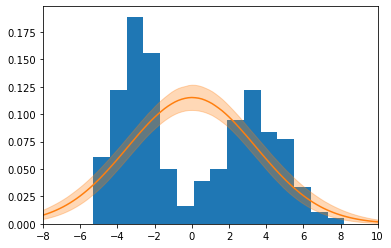

In [106]:
mu_sample = trace['mu'][::5]
std_sample = trace['std'][::5]

X_plot = np.linspace(-8,10,100)

pdf = np.empty((mu_sample.shape[0],100))
for i,param in enumerate(zip(mu_sample, std_sample)):
    pdf[i,:] = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
pdf_med = np.median(pdf,axis=0)
pdf_ub = np.percentile(pdf,axis=0,q=97.5)
pdf_lb = np.percentile(pdf,axis=0,q=2.5)

plt.hist(All, density=True, bins=20, range=(-8,10),zorder=0)
plt.plot(X_plot, pdf_med,zorder=1)
plt.fill_between(X_plot, pdf_lb, pdf_ub, alpha=0.3, color='C1',zorder=2)
plt.xlim(-8,10)
plt.show()

You can see that we get one flat Normal distribution which is quite different from either of the original two distributions.<br>
How can we do better?<br>

From the histogram above, we can notice that fitting two normal distributions would be better than fitting one for all the datapoints.<br>
The problem is that, we do not know which datapoint belongs to which distribution!<br>

To solve this probelm, we introduce a discrete variable, $z$, into our problem. We assume that, each datapoint inherently has a discrete value (either 0 or 1) that represents which distribution the datapoint belongs to. But, it's a hidden (latent/unobsevable/unmeasurable) variable.<br>

Now, we estimate $z$ for each data point as well as model parameters ($\mu_1, \mu_2, \sigma_1, \sigma_2$). Let's sample $z_{1:D}$, $\mu$'s and $\sigma$'s.

In [108]:
# log likelihood, normal distribution
def llk_norm(X, mu, tau):
    return (-tau * (X - mu)**2. + T.log(tau / np.pi / 2.)) / 2.

# log liklihood with two normal distributions.
# if z=0, calculate the log likelihood with the first normal distribution, 
# if z=1, calculate the log likelihood with the second normal distribution.
def llk_mixture(mu=None, std=None, z=None, X=None):
    mu1 = mu[0]
    std1 = std[0]
    tau1 = 1./std1**2.
    llk_norm1 = llk_norm(X=X, mu=mu1, tau=tau1)[:,None]
    
    mu2 = mu[1]
    std2 = std[1]
    tau2 = 1./std2**2.
    llk_norm2 = llk_norm(X=X, mu=mu2, tau=tau2)[:,None]
    
    llk_mixture = T.concatenate((llk_norm1, llk_norm2),axis=1)
        
    return T.sum(llk_mixture[T.arange(X.shape[0]),z])

In [109]:
model_mixture = pm.Model()
with model_mixture:
    mu = pm.Normal('mu', mu=0, sd=10, shape=2) # two mu's
    std = pm.Exponential('std', lam=1/10., shape=2) # two sigma's
    pi = pm.Dirichlet('pi', np.ones(2)) # you can ignore it for now
    z = pm.Categorical('z',p=pi,shape=All.shape[0]) # z values
    obs = pm.Potential('obs',llk_mixture(mu=mu, std=std, z=z, X=All)) # custom likelihood
    
    trace = pm.sample(draws=5000)

C:\Users\Public\Documents\ESTsoft\CreatorTemp/ipykernel_20220/2514879392.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws=5000)#, tune=10000, step=[step_cont,step_disc], chains=1, cores=1)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [pi, std, mu]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 223 seconds.
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:560: RuntimeWarning: invalid value encountered in sqrt
  rhat_value = np.sqrt(
C:\Users\Seungjae Lee\.conda\envs\pymc_env\lib\site-packages\arviz\stats\diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [153]:
mu_sample = trace['mu'][::5,:]
std_sample = trace['std'][::5,:]

idx = (mu_sample>0)
mu_1_sample = mu_sample[idx]
std_1_sample = std_sample[idx]
mu_2_sample = mu_sample[~idx]
std_2_sample = std_sample[~idx]

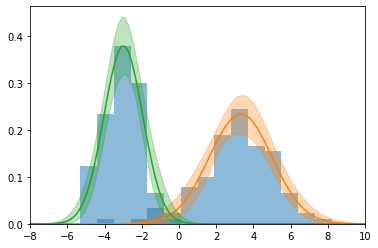

In [156]:
pdf_1 = np.empty((mu_1_sample.shape[0],100))
pdf_2 = np.empty((mu_2_sample.shape[0],100))
for i,param in enumerate(zip(mu_1_sample, std_1_sample, mu_2_sample, std_2_sample)):
    pdf_1[i,:] = stats.norm.pdf(x=X_plot,loc=param[0],scale=param[1])
    pdf_2[i,:] = stats.norm.pdf(x=X_plot,loc=param[2],scale=param[3])
pdf_1_med = np.median(pdf_1,axis=0)
pdf_1_ub = np.percentile(pdf_1,axis=0,q=97.5)
pdf_1_lb = np.percentile(pdf_1,axis=0,q=2.5)
pdf_2_med = np.median(pdf_2,axis=0)
pdf_2_ub = np.percentile(pdf_2,axis=0,q=97.5)
pdf_2_lb = np.percentile(pdf_2,axis=0,q=2.5)

plt.hist(x1, density=True, alpha=0.5, bins=20, range=(-8,10), color='C0')
plt.hist(x2, density=True, alpha=0.5, bins=20, range=(-8,10), color='C0')
plt.plot(X_plot, pdf_1_med,zorder=1,c='C1')
plt.fill_between(X_plot, pdf_1_lb, pdf_1_ub, alpha=0.3, color='C1',zorder=2)
plt.plot(X_plot, pdf_2_med,zorder=1,c='C2')
plt.fill_between(X_plot, pdf_2_lb, pdf_2_ub, alpha=0.3, color='C2',zorder=2)
plt.xlim(-8,10)
plt.show()

The model discovered two normal distributions! In other words, two sub-models for two groups (clusters) of data.

## Homework
So, can we do similar work with our previous data? I know it will be challenging.

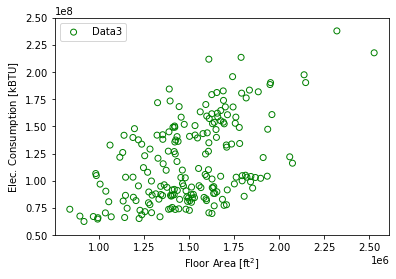

In [157]:
# import / plot data
Data3 = pd.read_excel(os.path.join(os.path.dirname('__file__'), '..', 'data', 'Data.xlsx'))

plt.scatter(Data3['Area [sq ft]'], Data3['Elec [kBTU]'], facecolors='None', edgecolors='green', label='Data3')

plt.xlabel('Floor Area [$\mathrm{ft}^2$]')
plt.ylabel('Elec. Consumption [$\mathrm{kBTU}$]')
plt.ylim(0.5e+8, 2.5e+8)
plt.legend()
plt.show()

### Questions
+ How can we determine the optimal number of clusters for our dataset?